# Particle Tracking Code - Demonstration of using this code for doing quantitative phase imaging

We'll use the *widely* used particle tracking code that's based on code developed by [John Crocker](http://crocker.seas.upenn.edu/). Originally, that code was developed in IDL. But others have rewritten it in Matlab (for example, [here](http://site.physics.georgetown.edu/matlab/)) and in Python. We'll use the Python code which is provided by [Maria Kilfoil](http://people.umass.edu/kilfoil/). 

The Python particle tracking code we'll use was grabbed from [here](http://people.umass.edu/kilfoil/tools.php). But I've made some slight changes (necessary for how we'll load the images and given the updated version of Python we're using). 

First, I recommend that you go over the tutorial in the ParticleTracking-Python repository that is in the folder "jupyter_notebooks" and called `Particle Tracking -- DEMONSTRATION, TUTORIAL.ipynb`. 

In that tutorial, you track beads which are diffusing around. One of the first things to do in that video was to make sure the contrast was right. That is, you needed to use ImageJ to make sure the things to be tracked appear as white objects on a black background like shown in the image below. 

![Background-subtracted image](..\jupyter_notebooks\Silica700_2018-05-16_bgsub.png). 

### First, import the necessary libraries. Note that you may need to install pyGrad2Surf.

That pyGrad2Surf can be downloaded here: https://gitlab.com/chjordan/pyGrad2Surf. You can find installation instructions there. If you can't get that to install, then you can just comment out the `from pyGrad2Surf.g2s import g2s` line for now. 

In [1]:
#importing the required modules
import numpy as np #Numerical Python
import scipy #Scientific Python

%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt


#Loading the particle tracking software
import sys
sys.path.append("..\\track") #Locate code
import mpretrack #The file mpretrack.py and trackmem.py should be in the location above
import trackmem
import bpass
import tiff_file #Ignore any warnings importing this may cause

from scipy import interpolate

from pyGrad2Surf.g2s import g2s  ##see: https://gitlab.com/chjordan/pyGrad2Surf

from mpl_toolkits.mplot3d import Axes3D

..\track\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
..\track\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
..\track\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


#### You may need to edit the location of the data in the cell below

In [2]:
#Now let's locate the data


data_directory = '.\\'
data_file = "crop_candle_in_front.tif"

### Let's inspect the data

We'll show the first frame of the movie we'll use. 
Then we'll show what that frame looks like when we filter it using a bandpass filter.

We see a bunch of white dots. These are dots displayed on the eInk screen. The eInk screen is used in a microscope setup. 

<IPython.core.display.Javascript object>


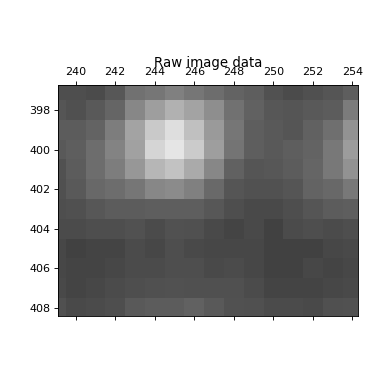

<IPython.core.display.Javascript object>


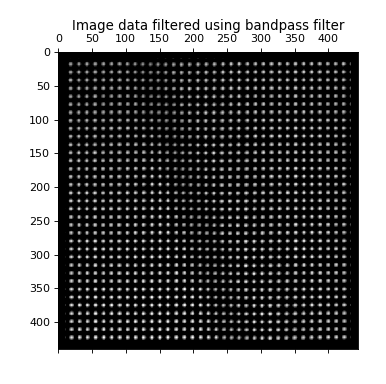

<IPython.core.display.Javascript object>


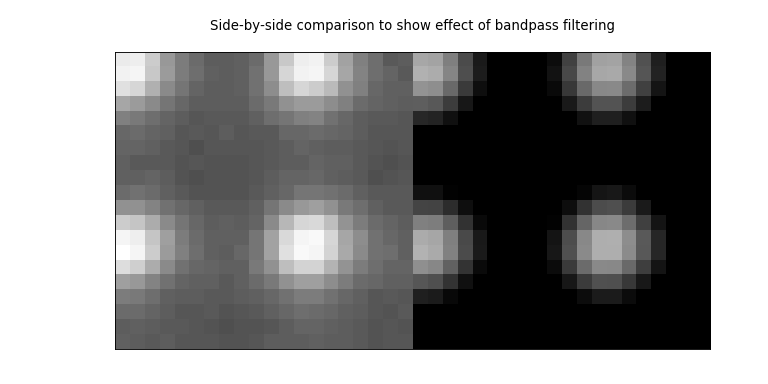

In [3]:
#We use the "tiff_file" module to deal with image data in tif formats.
#The function 'imread' reads in the image. We can either read in the whole entire
#  movie or just read in a specific frame. Here, we are reading in only the first 
#  frame. We do this by setting the optional paratmer 'key' equal to 0. 
frame1_image = tiff_file.imread(data_directory+data_file,key=0)

plt.matshow(frame1_image, cmap=matplotlib.cm.gray) #'cmap' is the colormap used
plt.title("Raw image data") #title the figure

#Let's try filtering the data with a bandpass filter. This filter is used when
#  identifying features in the image. 
#  Note that the first number given is 1 and that will usually not change. 
#  The second number given is 11. That will mean that features in the image that
#    are larger than 11 pixels will be filtered out. So if the dots in your image
#    appear larger than 11 pixels in size, use a bigger number. 
bpass_image = bpass.bpass(frame1_image,1,11) 

plt.matshow(bpass_image, cmap=matplotlib.cm.gray)
plt.title("Image data filtered using bandpass filter")

#We'll show a side-by-side comparison of non-filtered and filtered images.
# Using the numpy function 'hstack' to combine two arrays horizontally
plt.matshow(np.hstack((frame1_image[18:38,42:62], bpass_image[18:38,42:62])), cmap=matplotlib.cm.gray, interpolation='nearest')
plt.xticks([]); plt.yticks([]) #This removes the labeling of the axes values
plt.title('Side-by-side comparison to show effect of bandpass filtering');

<IPython.core.display.Javascript object>


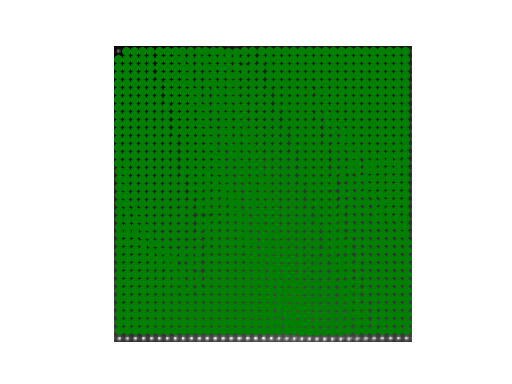


-----------TEST-----------
1331 features found.
Intensity of 1st particle: 1159.54
Rg of 1st particle: 4.39
Eccentricity of 1st particle: 0.0668
[[3.74897137e+02 6.81356088e+00 1.15953866e+03 4.38825552e+00
  6.68329542e-02]
 [4.10460815e+02 6.81010642e+00 1.12308895e+03 4.56977271e+00
  8.12913825e-02]
 [4.22385983e+02 6.78550249e+00 1.10675164e+03 4.52406713e+00
  7.48631314e-02]
 ...
 [3.37481951e+02 4.23936954e+02 1.47108370e+03 5.32302634e+00
  8.35164522e-02]
 [3.49729962e+02 4.23690347e+02 1.49705606e+03 5.79536425e+00
  9.63207683e-02]
 [3.62320931e+02 4.23500543e+02 1.43967780e+03 5.88786851e+00
  1.01380460e-01]]
1331 features kept.
Minimum Intensity : 819.8362439511061
Maximum Rg : 5.887868508496544
Maximum Eccentricity : 0.12612903572547196
--------------------------


In [16]:
#Use the function 'test' in mpretrack to find good set of parameters

###############################################################################
# Options from mpretrack:
#    barI: minimum integrated intensity
#    barRg: maximum radius of gyration squared (in pixel squared)
#    barCc: minimum eccentricity accepted
#    IdivRg: minimum ratio of of integrated intensity to radius of gyr sqrd
#    Imin: minimum intensity of local max -- set to 0 to use default "top 30%"
#    masscut: threshold for integrated intesnity of features before refinement
#    field: 2 for full frame (0 or 1 if interlaced video)
###############################################################################

%matplotlib notebook

frame_num = 1 #We'll use the first frame
feature_size = 5 #Expected size of "features" (aka, the white dots). Here we have it as 5 pixels
plt.figure()
mt, mrej = mpretrack.test(data_directory,data_file,frame_num,feature_size,
                          masscut = 800, Imin=40, barI = 10, barRg = 20,
                          barCc = 0.9, IdivRg=0.9, verbose=True, bandpass='bp');

###############################################################################
#   In the image below, we will see green dots where the features have        #
#   been identified by the program. If some features do not have green        #
#   dots appearing on top of them, then we might need to adjust some of       #
#   the parameters given above.                                               #
###############################################################################

Did that look okay? You should see a figure appear with green dots where the program found particles. Red dots indicate that particles were identified but then discarded due to not meeting the thresholds (like being below the minimum integrated intensity or exceeding the maximum radius of gyration).

Now we'll run the feature-finding algorithm with the paramters we found on *all* frames.

In [19]:
###########################################################################
# Now let's find the features in two different frames. 
# We'll specify the first frame to find features in 
#   with the variable frame_1.
# The second frame to find features in will be stored
#   in the variable frame_2.
###########################################################################

#How many frames to find features in. Here we have it as 2.
num_frames = 2 #number of frames to find particles

#Identify the two frames to use.
frame_1 = 0
frame_2 = 10

ims = tiff_file.imread(data_directory+data_file,key=[0,frame_2])

#Same parameters used as in "test".
#NOTE: I set verbose=False here so it doesn't print out too much 
#But you should set verbose=True. 
#It will then print out how many particles found in each frame.

mt = mpretrack.run_v2(ims,feature_size,
                   masscut = 800, Imin=40, barI = 10, barRg = 20,
                   barCc = 0.9, IdivRg=0.9, bandpass='bp')

1331 features found.
Frame 0
1331 features kept.
1331 features found.
1331 features kept.


The variable `mt` now has the information about the features found in both frames.

In [20]:
print "The dimensions of mt: ", mt.shape

The dimensions of mt:  (2662L, 7L)


From the above bit of code we see that the dimensions of `mt` are a large number by 7. The first number (which should be 2574 unless you have changed numbers in this example) is the number of features found in total (from both frames). The number 7 refers to the number of quantities calculated for each feature. For each feature found this program has determined the
0. x-position (units of pixels)
1. y-position (units of pixels)
2. brightness of the feature (adding up all the pixel values in some region around the feature)
3. square of the radius of gyration (measure of how big the feature is)
4. eccentricity of the feature (measure of how elliptical the feature is; 0 if perfectly circular)
5. frame number the feature was found in
6. time correspond to the frame (this will just be identical to the frame number)

Note that I started this list with 0. That is because Python starts indexing arrays with 0, not 1.

In [21]:
##########################################################################################
# Now we will try to link together features between the two frames that correspond to the
#   same dot which as just been shifted due to variations in refractive index.
#
# We'll define a new array called "mtnew" which will be like "mt" but will contain 
# new information.
#   index 7 will be track id (some number to identify the dots)
#   index 8 will be displacement (measured in pixels)
#   index 9 will be displacement just in the x-direction
#   index 10 will be displacement in y-direction
#   index 11 will be the change in r_g

w = np.where(mt[:,5]==0)[0] #Finding dots where in the first frame
num_dots_in_first_frame = w.max() + 1 #The number of dots found in the first frame
print "num in first frame: ", num_dots_in_first_frame

mtnew = np.zeros((mt.shape[0],mt.shape[1]+6)) #initialize the new array
mtnew[:,:7] = mt.copy() #fill the first 7 columns of new array with original "mt" data

#loop through all the features found in the first frame
for i in range(num_dots_in_first_frame):
    #Caculate the displacement between a feature and all other features found
    disp = np.power(mt[i,0]-mt[:,0],2) + np.power(mt[i,1]-mt[:,1],2)
    
    #Sort that displacement from smallest to largest
    sort_disp = np.argsort(disp) #the first arg will be the same dot; second one will be from next frame
    
    
    the_disp = disp[sort_disp[1]]
    if (mtnew[i,7] == 0) and (mtnew[sort_disp[1],5]==1) and (the_disp < 40):
        #above if statement checks that the dot hasn't been assigned an ID yet and that it's associated
        # dot is indeed in the next frame
        if (mtnew[sort_disp[1],7]!=0 and the_disp<mtnew[sort_disp[1],8]) or (mtnew[sort_disp[1],7]==0):
            mtnew[i,7] = i
            mtnew[sort_disp[1],7] = i
            xdisp = mt[i,0]-mt[sort_disp[1],0]
            ydisp = mt[i,1]-mt[sort_disp[1],1]
            mtnew[i,8] = disp[sort_disp[1]]
            mtnew[sort_disp[1],8] = disp[sort_disp[1]]
            mtnew[i,9] = xdisp
            mtnew[i,10] = ydisp
            mtnew[i,11] = mt[i,3] - mt[sort_disp[1],3] #change in radius
            mtnew[i,12] = mt[i,4] - mt[sort_disp[1],4] #change in eccentricity
        
new_tracks = mtnew[:num_dots_in_first_frame,:].copy()

num in first frame:  1331


What's in <code>new_tracks</code>?
+ <code>tracks[:,0]</code> is the *x*-coordinate of particle (in terms of pixel) in first frame
+ <code>tracks[:,1]</code> is the *y*-coordinate
+ <code>tracks[:,2]</code> is the integrated brightness of found features
+ <code>tracks[:,3]</code> is the square of the radius of gyration
+ <code>tracks[:,4]</code> is the eccentricity (zero for circularly symmetric features)
+ <code>tracks[:,5]</code> is the frame number
+ <code>tracks[:,6]</code> is the time
+ <code>tracks[:,7]</code> is the trajectory ID number
+ <code>tracks[:,8]</code> is the displacement between frames 1 and 2
+ <code>tracks[:,9]</code> is the x-displacement
+ <code>tracks[:,10]</code> is the y-displacement
+ <code>tracks[:,11]</code> is the *change* in the radius of gyration

<IPython.core.display.Javascript object>


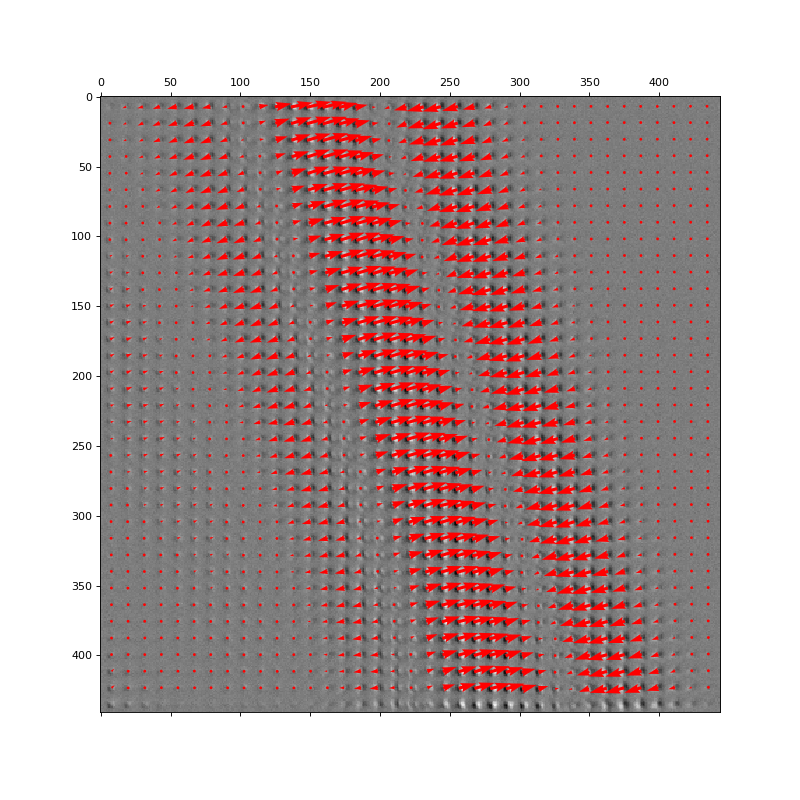

In [31]:
#########################################################################
# Here we use a "quiver plot" to show the displacement of each dot.     #
#########################################################################

%matplotlib notebook
fig = plt.figure(figsize=(10,10))
frame1_image = tiff_file.imread(data_directory+data_file,key=frame_1)
frame2_image = tiff_file.imread(data_directory+data_file,key=frame_2)
plt.matshow(-1*frame1_image + frame2_image, cmap=matplotlib.cm.gray, fignum=0)
plt.quiver(new_tracks[:,0],new_tracks[:,1], -1*new_tracks[:,9], new_tracks[:,10], scale=50, color='r', width=0.005)

## Note: you can change the "scale" parameter to better show the arrows which 
##   indicate the shift in each dot


## Next, we further process this data. 

Don't worry about fully understanding what happens next.

In [32]:
frame1_image = tiff_file.imread(data_directory+data_file,key=frame_1)
frame2_image = tiff_file.imread(data_directory+data_file,key=frame_2)
#plt.matshow(-1*frame1_image + frame2_image, cmap=matplotlib.cm.gray)
w = np.where(new_tracks[:,1]<55)[0]
#plt.quiver(new_tracks[w,0],new_tracks[w,1], -1*new_tracks[w,9], new_tracks[w,10], scale=80, color='r', width=0.005)
print "Mean x-disp: ", new_tracks[w,9].mean()
print "Mean y-disp: ", new_tracks[w,10].mean()
offset_x = new_tracks[w,9].mean()
offset_y = new_tracks[w,10].mean()

Mean x-disp:  0.0741444034774782
Mean y-disp:  -0.05188621507314676


In [33]:
#u = interpolate.interp2d(new_tracks[:,0],new_tracks[:,1], -1*new_tracks[:,-2], kind='linear',fill_value=0) 
#v = interpolate.interp2d(new_tracks[:,0],new_tracks[:,1], new_tracks[:,-1], kind='linear',fill_value=0)

points = np.transpose(np.vstack((new_tracks[:,0],new_tracks[:,1])))
u = interpolate.CloughTocher2DInterpolator(points, new_tracks[:,9] - offset_x, fill_value=0)
v = interpolate.CloughTocher2DInterpolator(points, new_tracks[:,10] - offset_y, fill_value=0)

<IPython.core.display.Javascript object>


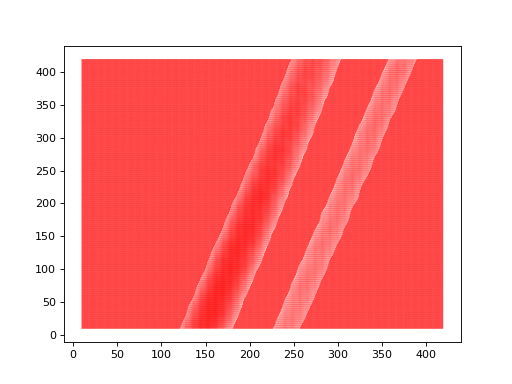

In [34]:
%matplotlib notebook
plt.figure()
x = np.arange(10, 420, 1)
y = np.arange(10, 420, 1)
xx,yy = np.meshgrid(x, y)
plt.quiver(x, y, u((xx,yy)), v((xx,yy)), color='r')

In [36]:
reconstructed = g2s(x, y, u((xx,yy)), v((xx,yy)))

<IPython.core.display.Javascript object>


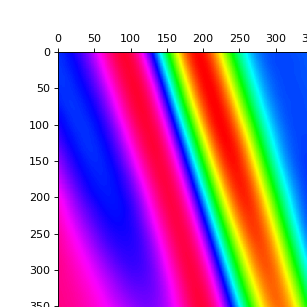

In [37]:
plt.matshow(reconstructed, cmap=matplotlib.cm.hsv)

<IPython.core.display.Javascript object>


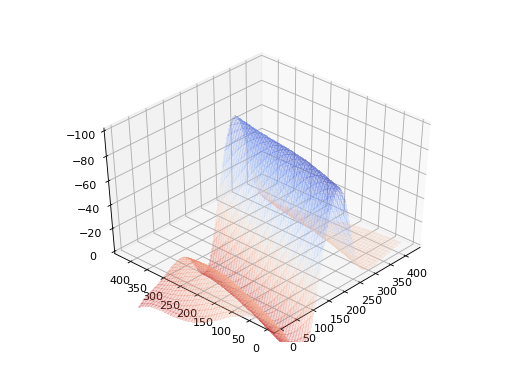

(0, -100)

In [38]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx,yy, reconstructed-reconstructed.mean(), cmap=matplotlib.cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.2)

ax.set_zlim(0, -100)